## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal is to help a company understand if they should implement the new page, keep the old page or run the experiment longer to make their decision using the results of an A/B test run by an e-commerce website.

The following fields are provided:
1. User ID - unique ID asssigned to each user registered on the website
2. Timestamp - timestamp at which they visit the website
3. group - control group (given the old page) and treatment group (given the new page)
4. landing_page - old or new page
5. converted - 0 implies that the user is not converted to a customer and 1 implies that the user is now a customer of the webiste since he/she has made a purchase

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# to ensure consistency in results
random.seed(42)

In [2]:
# workaround for error - AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
# alternative method
# df[((df['group'] != 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))].shape[0]
df[(df['group'] == 'treatment') ^ (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Handle these rows.

a. Create a new dataframe identified by `df2` using the cleaned up data

In [9]:
df2 = df.drop(df[(df['group'] == 'treatment') ^ (df['landing_page'] == 'new_page')].index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double checking if all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Continue analysis using **df2**

a. How many unique **user_ids** are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id[df2.user_id.duplicated() == True]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset=['user_id'], inplace=True)
df2.shape[0]

290584

In [15]:
# Double checking if all of the correct rows were removed - this should be 0
df2.user_id[df2.user_id.duplicated() == True].count()

0

`4.` Use **df2** to continue the analysis as below

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_conversion_rate = df2.query('group == "control"')['converted'].mean()
control_conversion_rate

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_conversion_rate = df2.query('group == "treatment"')['converted'].mean()
treatment_conversion_rate

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The probability that an individual receives the old or new page is approximately equal. So we can presume that the control and treatment groups have equal strength.**

**The probability of conversion of an individual regardless of which group they belong to is quite low (less than 15%). The probability of conversion of an individual belonging to the control and treatment groups is comparable. Hence, we cannot determine which page is favoured.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_{0} : p_{new} - p_{old} \leq 0 $$ <br>
$$ H_{1} : p_{new} - p_{old} > 0 $$

**Null Hypothesis: The old page is as good as or better than the new page**<br>
**Alternate Hypothesis: The old page is worse than the new page**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 1, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 1, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_new_simulated = new_page_converted.mean()
p_new_simulated

0.1210859541669534

In [27]:
p_old_simulated = old_page_converted.mean()
p_old_simulated

0.12083373487341162

In [28]:
p_new_simulated - p_old_simulated

0.00025221929354178607

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_new_simulated = new_page_converted.mean()
    p_old_simulated = old_page_converted.mean()
    p_diffs.append(p_new_simulated - p_old_simulated)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [30]:
obs_diff = treatment_conversion_rate - control_conversion_rate
obs_diff

-0.0015782389853555567

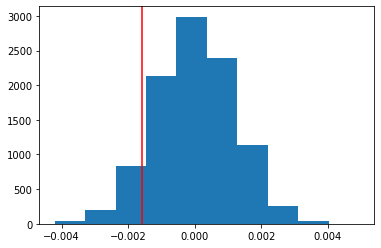

In [31]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
null_vals = np.random.normal(0, np.std(p_diffs), 10000)
proportion_of_p_diffs_greater_than_actual_diff = (obs_diff < null_vals).mean()
proportion_of_p_diffs_greater_than_actual_diff

0.9047

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The p-value is computed in the previous cell. The p-value is the probability of observing your statistic or one or more extreme in favor of the alternative if the null hypothesis is true.**<br>

**If the p-value is lesser than or equal to the alpha value (here 0.05), we reject the null hypothesis. If the p-value is greater than the alpha value, we fail to reject the null hypothesis.**<br>

**Here, the p-value is much greater than the alpha value, and hence we can conclude that we fail to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
# getting the number of conversions when the landing page provided to the user is old and new respectively
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

# getting the number of users provided with the old and new pages respectively
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

# alternative is one-sided and the first proportion (old) is smaller than the second proportion (new)
stat, pval = proportions_ztest(count, nobs, alternative='smaller')
print(stat, pval)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [35]:
# getting critical z-score for 95% confidence interval and p-value of 0.05
stats.norm.ppf(1-(0.05/2)) 

1.959963984540054

**The z-score gives us an idea of how far a data point is from the mean of the values. It is a measure of how many standard deviations above or below the mean of the values is the data point. Here, the z-score is equal to 1.31 which means that the score is 1.31 above the mean.**<br>

**The critical Z score values when using a 95% confidence level are -1.96 and +1.96 standard deviations. Since the Z score is between -1.96 and +1.96, we fail to reject the null hypothsis.**<br>

**The p-value (comparable to the value calculated in part j), as mentioned earlier, indicate that we fail to reject the null hypothesis. These results agree with the findings of parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression - since we are predicting a categorical response having only two possible outcomes namely converted and not converted**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1
df2[['ab_page_tbd', 'ab_page']] = pd.get_dummies(df['group'])
df2.drop(['ab_page_tbd'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
log_mod1 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results1 = log_mod1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        22:18:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value associated with the ab_page variable is 1-0.5*(0.19) = 0.905. This matches the results from the previous part. However, since the p-value is greater than 0.05, ab_page does not have any statistical significance.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value associated with ab_page in the above summary of results is 0.19.**<br>

**The p-value differs from that calculated in the previous section because in the previous section, we considered a one-sided alternate hypothesis. We only considered the portion of the graph beyond the red line. In the above regression model the hypothesis is two sided as follows:** <br>

$$ H_{0} : p_{new} - p_{old} = 0 $$ <br>
$$ H_{1} : p_{new} - p_{old} \neq 0 $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors to add to the regression model since we want to avoid misinterpreting the results. Simpson's paradox is an effect where groups of data show a particular trend and when the groups are combined, they show a different trend. By considering all the relevant factors, we can avoid reaching the wrong conclusions.** <br>

**However, there are disadvantages to adding additional terms to the regression model. Some of the disadvantages are as follows:**<br>
**1. The variables may be related to each other leading to collinearity between the X variables. This is undesirable as it results in inaccurate hypothesis testing results.**<br>
**2. In case the interaction between two factors or a higher order of a factor is considered, the interpretation of the regression coefficients associated with the raw factors becomes complicated.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [43]:
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        22:18:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**The p-values associated with CA, US and ab_page can be calculated as follows:**<br>

**CA: p-value = 1-(0.5 * 0.074) = 0.963**<br>
**US: p-value = 1-(0.5 * 0.457) = 0.7715**<br>
**ab_page: p-value = 1-(0.5 * 0.191) = 0.9045**<br>

**Since the p-values associated with none of the factors are lesser than 0.05, they are not statistically significant in the prediction of whether or not a user will be converted to a customer.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_page_CA,ab_page_US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [45]:
log_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US', 'ab_page', 'ab_page_CA', 'ab_page_US']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 25 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        22:18:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
ab_page_CA    -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_page_US    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

**The p-values associated with CA, US and ab_page can be calculated as follows:**<br>

**CA: p-value = 1-(0.5 * 0.767) = 0.6165**<br>
**US: p-value = 1-(0.5 * 0.76) = 0.62**<br>
**ab_page: p-value = 1-(0.5 * 0.635) = 0.6825**<br>
**ab_page_CA: p-value = 1-(0.5 * 0.168) = 0.916**<br>
**ab_page_US: p-value = 1-(0.5 * 0.238) = 0.881**<br>

**Since the p-values associated with none of the factors are lesser than 0.05, they are not statistically significant in the prediction of whether or not a user will be converted to a customer.**

<a id='conclusions'></a>
## Conclusion

The e-commerce website should retain the old page in their website since bringing in the new page did not have any significant effect with respect to increase in conversion of users into customers. This could be due any/all of the following reasons:
1. The old page of the website truely needed no revamping with respect to the user experience and design
2. Change aversion - existing users are unhappy with the change even though it is better than the older version

References:
1. Exclusive OR: https://stackoverflow.com/questions/432842/how-do-you-get-the-logical-xor-of-two-variables-in-python
2. Understanding Z-score: https://www.statisticshowto.com/probability-and-statistics/z-score/
3. How to read Z-scores: http://resources.esri.com/help/9.3/arcgisdesktop/com/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm
4. Calculating critical z-score: https://knowledge.udacity.com/questions/316691
5. Workaround for import error: https://github.com/statsmodels/statsmodels/issues/3931
6. Conversion of two-sided p-value to one-sided: https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-the-differences-between-one-tailed-and-two-tailed-tests/

In [46]:
# # creating HTML for submission
# from subprocess import call
# call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])